In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = "./dataset/CAC40_stocks_2021_2023.csv"
dataset = pd.read_csv(file_path)
validation_days = 20   # Nombre de jours de validation

# Data preprocessing
specific_stock = 'EN.PA'  # Remplacez par le nom du stock souhaité
if 'Stock' in dataset.columns:  # Vérifiez que la colonne existe
    data = dataset[dataset['Stock'] == specific_stock]
data_minus_validation = data[:-validation_days]
data_minus_validation

,Date,Open,High,Low,Close,Adj Close,Volume,Stock
4632,2020-04-08,28.000000,29.270000,27.590000,29.040001,23.951988,1154520.0,EN.PA
4633,2020-04-09,29.600000,30.260000,28.540001,30.260000,24.958237,1582217.0,EN.PA
4634,2020-04-14,30.200001,30.219999,28.719999,28.850000,23.795277,1394100.0,EN.PA
4635,2020-04-15,28.570000,28.700001,26.850000,26.850000,22.145693,2363412.0,EN.PA
4636,2020-04-16,27.000000,27.410000,25.450001,25.450001,20.990982,3040337.0,EN.PA
...,...,...,...,...,...,...,...,...
5379,2023-03-03,32.730000,32.750000,32.540001,32.610001,32.610001,798300.0,EN.PA
5380,2023-03-06,32.779999,32.840000,32.619999,32.680000,32.680000,1194076.0,EN.PA
5381,2023-03-07,32.700001,32.709999,32.320000,32.400002,32.400002,979918.0,EN.PA
5382,2023-03-08,32.400002,32.820000,32.259998,32.709999,32.709999,1237154.0,EN.PA


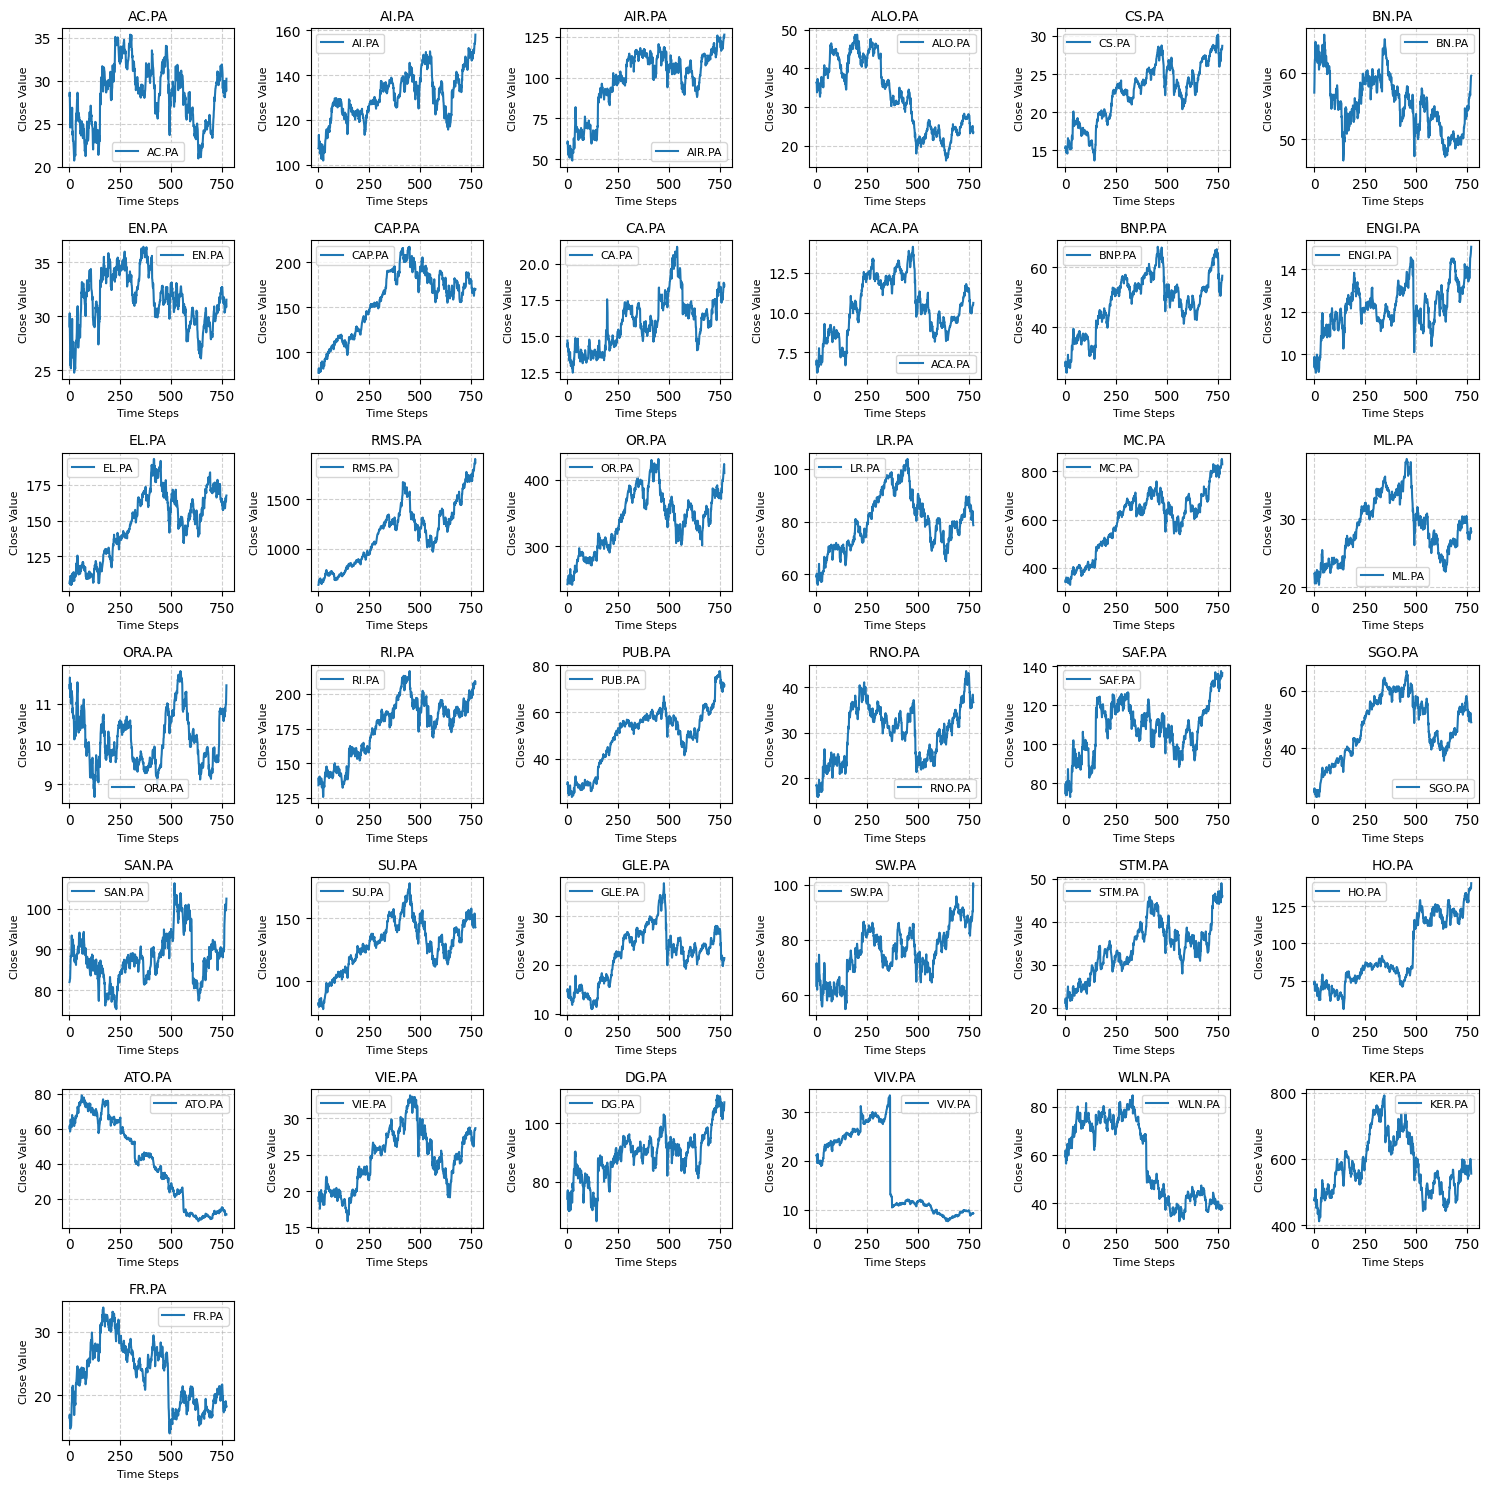

In [99]:
plt.figure(figsize=(15, 15))
unique_stocks = dataset['Stock'].unique()
num_stocks = len(unique_stocks)

# Calculate grid size
rows = int(np.ceil(np.sqrt(num_stocks)))
cols = int(np.ceil(num_stocks / rows))

for i, stock_name in enumerate(unique_stocks, 1):
    stock_data = dataset[dataset['Stock'] == stock_name]
    plt.subplot(rows, cols, i)
    plt.plot(stock_data['Close'].values, label=stock_name)
    plt.title(stock_name, fontsize=10)
    plt.xlabel("Time Steps", fontsize=8)
    plt.ylabel("Close Value", fontsize=8)
    plt.legend(fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [100]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

In [101]:
scaled_data = scaler.fit_transform(data_minus_validation['Close'].values.reshape(-1, 1)) 

In [102]:
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [103]:
time_step = 100
X, y = create_dataset(scaled_data, time_step)

In [104]:
train_size = 0.8

In [105]:
train_size = int(len(X) * 0.8)  # 80% for training
val_size = int(len(X) * 0.15)    # 15% for validation

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)
print("Test data shape:", X_test.shape, y_test.shape)

Training data shape: (520, 100) (520,)
Validation data shape: (97, 100) (97,)
Test data shape: (34, 100) (34,)


Finding best hyperparameters

In [106]:
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense, LSTM

def build_model(hp):
    model = Sequential()
    # Tune the number of LSTM units
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=256, step=32)
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    activation_function = hp.Choice('activation_function', values=['relu', 'tanh'])

    model.add(LSTM(units=lstm_units, activation=activation_function, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(units=lstm_units, activation=activation_function))
    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Use Keras Tuner to find the best hyperparameters
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='stock_prediction'
)

# Perform the search
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hps.values)

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Reloading Tuner from my_dir/stock_prediction/tuner0.json
Best Hyperparameters: {'lstm_units': 256, 'dense_units': 128, 'activation_function': 'tanh', 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012'}


/home/abel/personnal_projects/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 100, 256)       │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 822,529 (3.14 MB)

 Trainable params: 822,529 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

In [107]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Surveille la perte sur l'ensemble de validation
    patience=10,         # Arrête après 10 epochs sans amélioration
    restore_best_weights=True  # Restaure les poids du meilleur modèle
)

history = best_model.fit(
    X_train, y_train,
    epochs=100,  # Nombre maximum d'epochs
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
15/33 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.1872 - mae: 0.3508

KeyboardInterrupt: 

In [ ]:
test_loss = best_model.evaluate(X_test, y_test)
test_loss

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.5734e-04 - mae: 0.0239


[0.0008544375305064023, 0.023921038955450058]

In [ ]:
predictions = best_model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/stepWARNING:tensorflow:6 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x75dfa1e105e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


In [ ]:
original_data = data_minus_validation['Close'].values
predicted_data = np.empty_like(original_data)
predicted_data[:] = np.nan
predicted_data[-len(predictions):] = predictions.reshape(-1)

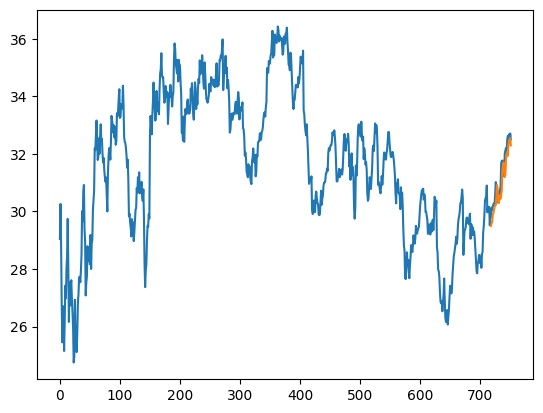

In [ ]:
plt.plot(original_data)
plt.plot(predicted_data)

In [ ]:
new_predictions = best_model.predict(X_test[-validation_days:])
new_predictions = scaler.inverse_transform(new_predictions)
predicted_data = np.append(predicted_data, new_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


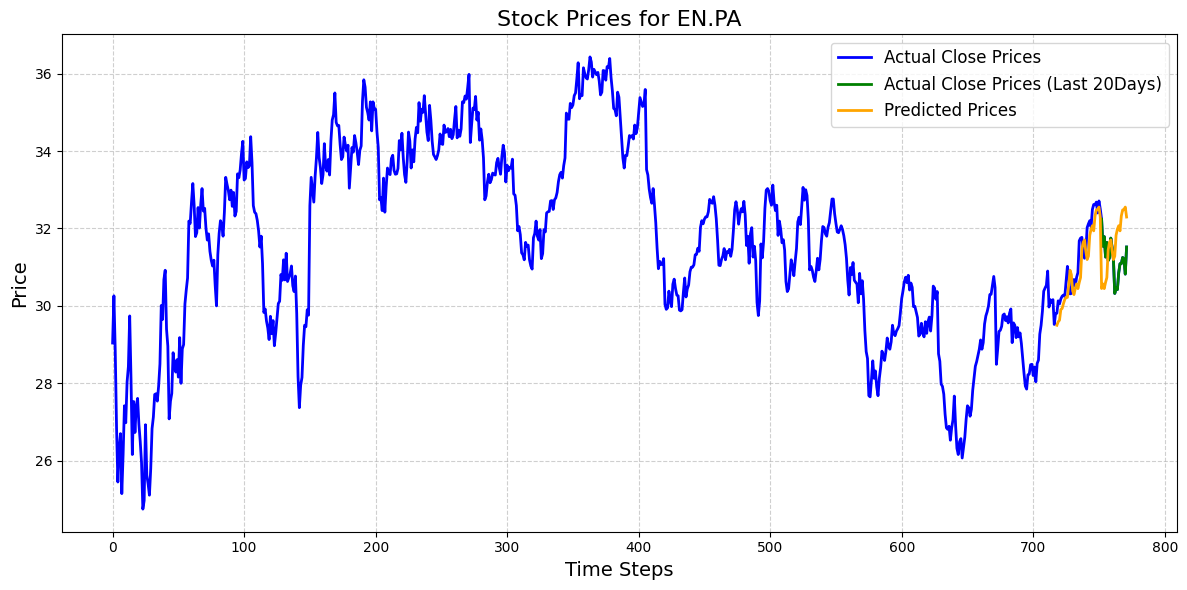

In [ ]:
plt.figure(figsize=(12, 6))  # Set the figure size

# Plot the entire Actual Close Prices in blue
plt.plot(data['Close'].values, label='Actual Close Prices', color='blue', linewidth=2)

# Highlight the last validation_days of Actual Close Prices in green
plt.plot(range(len(data['Close']) - validation_days, len(data['Close'])), data['Close'].values[-validation_days:], color='green', linewidth=2, label=f'Actual Close Prices (Last {validation_days}Days)')

# Plot the Predicted Prices in orange
plt.plot(predicted_data, label='Predicted Prices', color='orange', linestyle='-', linewidth=2)

# Add labels, title, and legend
plt.title(f"Stock Prices for {specific_stock}", fontsize=16)
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)  # Add a grid for better readability
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

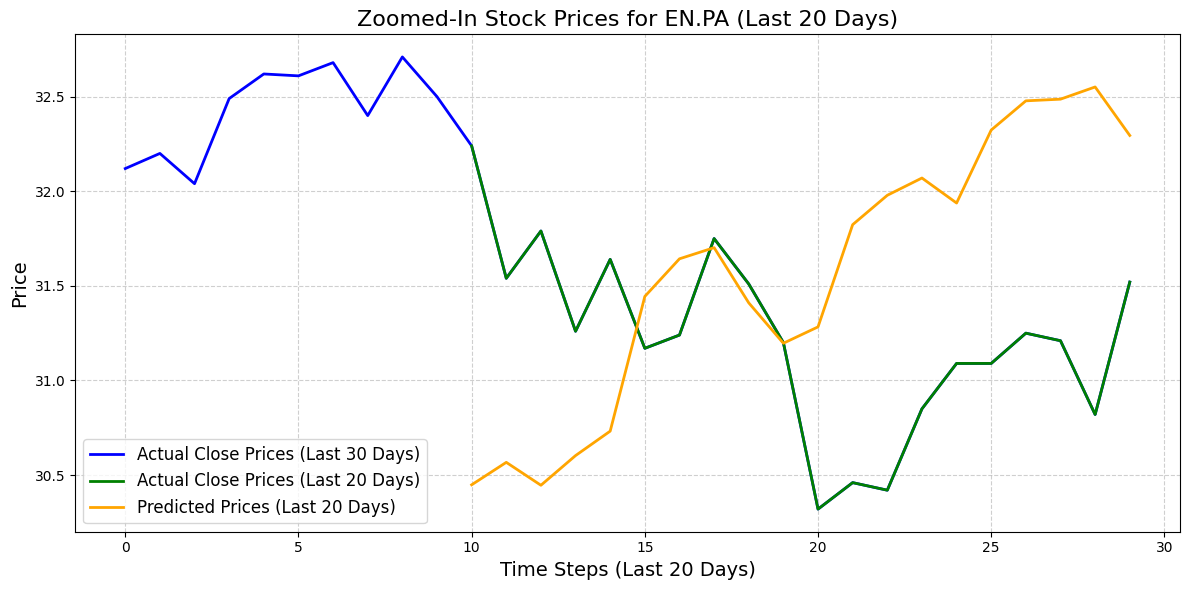

In [ ]:
plt.figure(figsize=(12, 6))  # Set the figure size

# Plot the last (validation_days + 10) days of Actual Close Prices in blue
plt.plot(data['Close'].values[-(validation_days + 10):], label=f'Actual Close Prices (Last {validation_days + 10} Days)', color='blue', linewidth=2)

# Plot the last validation_days of Actual Close Prices in green, starting after 10 days
plt.plot(range(10, 10 + validation_days), data['Close'].values[-validation_days:], label=f'Actual Close Prices (Last {validation_days} Days)', color='green', linewidth=2)

# Plot the last validation_days of Predicted Prices in orange, starting after 10 days
plt.plot(range(10, 10 + validation_days), predicted_data[-validation_days:], label=f'Predicted Prices (Last {validation_days} Days)', color='orange', linestyle='-', linewidth=2)

# Add labels, title, and legend
plt.title(f"Zoomed-In Stock Prices for {specific_stock} (Last {validation_days} Days)", fontsize=16)
plt.xlabel(f"Time Steps (Last {validation_days} Days)", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)  # Add a grid for better readability
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()